In [1]:
import sys
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from evals import load_models
from utils import *
from group_data import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
%load_ext autoreload
%autoreload 2

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [18]:
path = '/workspace/models/2024_07_31_23_04_49_Z48_2_d128'
models, params = load_models(path)

100%|██████████| 667/667 [02:20<00:00,  4.75it/s]


In [19]:
dataset = GroupData(params)

Intersection size: 9216/9216 (1.00)
Added 9216 elements from intersection
Added 0 elements from group 0: Z(48,2)
Taking random subset: 3686/9216 (0.40)
Train set size: 3686/9216 (0.40)


In [20]:
model0 = models[20][0].to(device)
model1 = models[-1][0].to(device)

In [25]:
#eps_l = [1.3**m for m in range(-80, -20)]
eps_l = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#eps_l = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
#eps_l = [1e-6, 2e-6, 5e-6, 1e-5]
beta_l = [1, 10, 100, 1000, 10000]
#beta_l = [10, 100, 1000]
gamma_l = [1_000.]
llc0, trace0 = sweep_llc(
    model0, dataset, eps_l, beta_l, gamma_l, chains=1, epochs=3_000, replacement=True, positive=False,#batch_size=128,
)

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

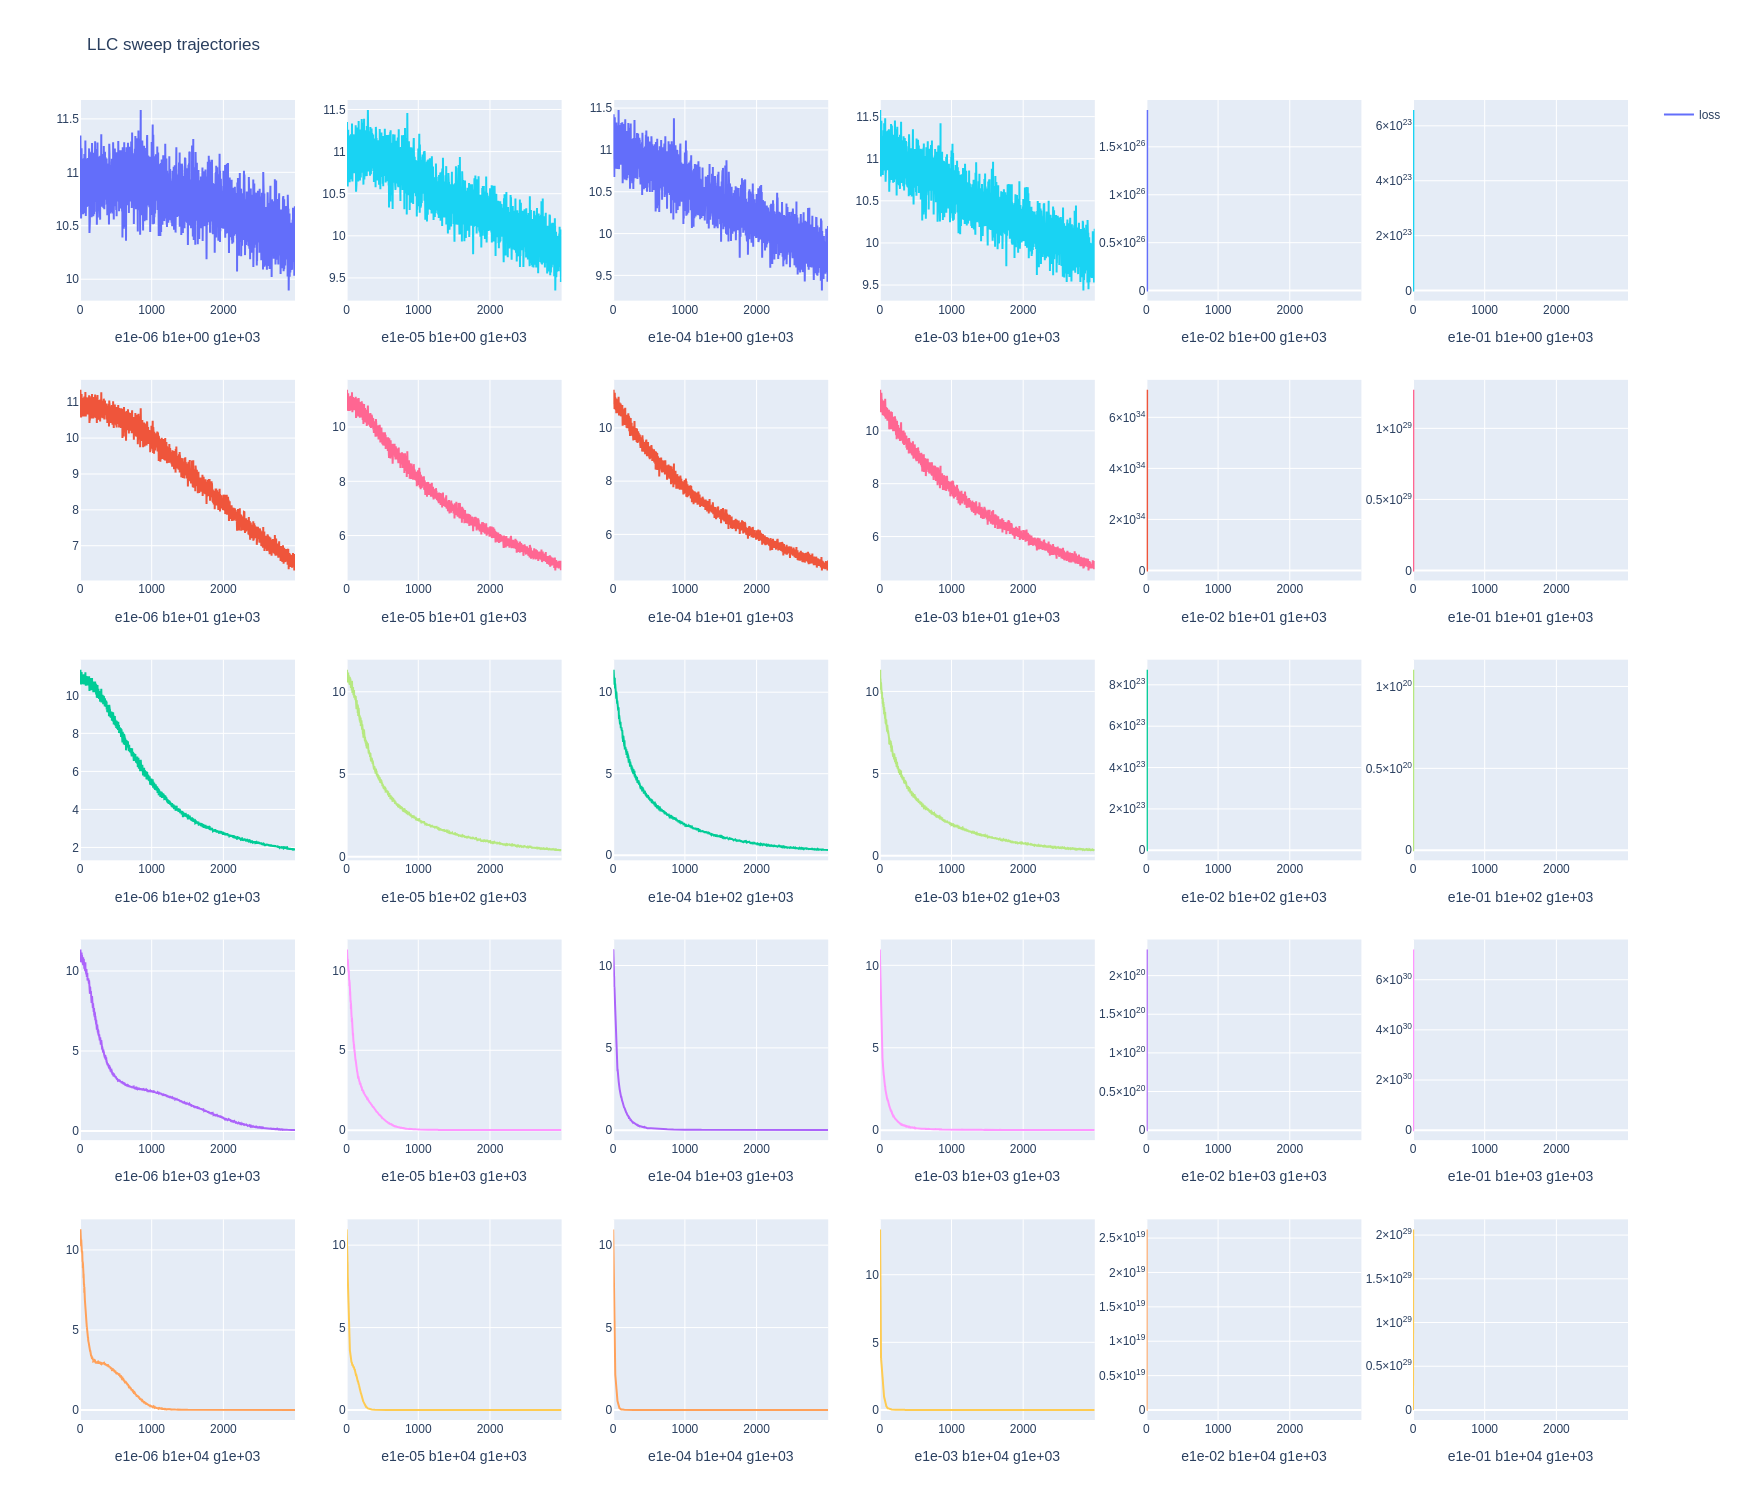

In [26]:
plot_trace_sweep(trace0, eps_l, beta_l, gamma_l).show()

In [27]:
llc1, trace1 = sweep_llc(
    model1, dataset, eps_l, beta_l, gamma_l, chains=1, epochs=3_000, replacement=True, positive=False,
)

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

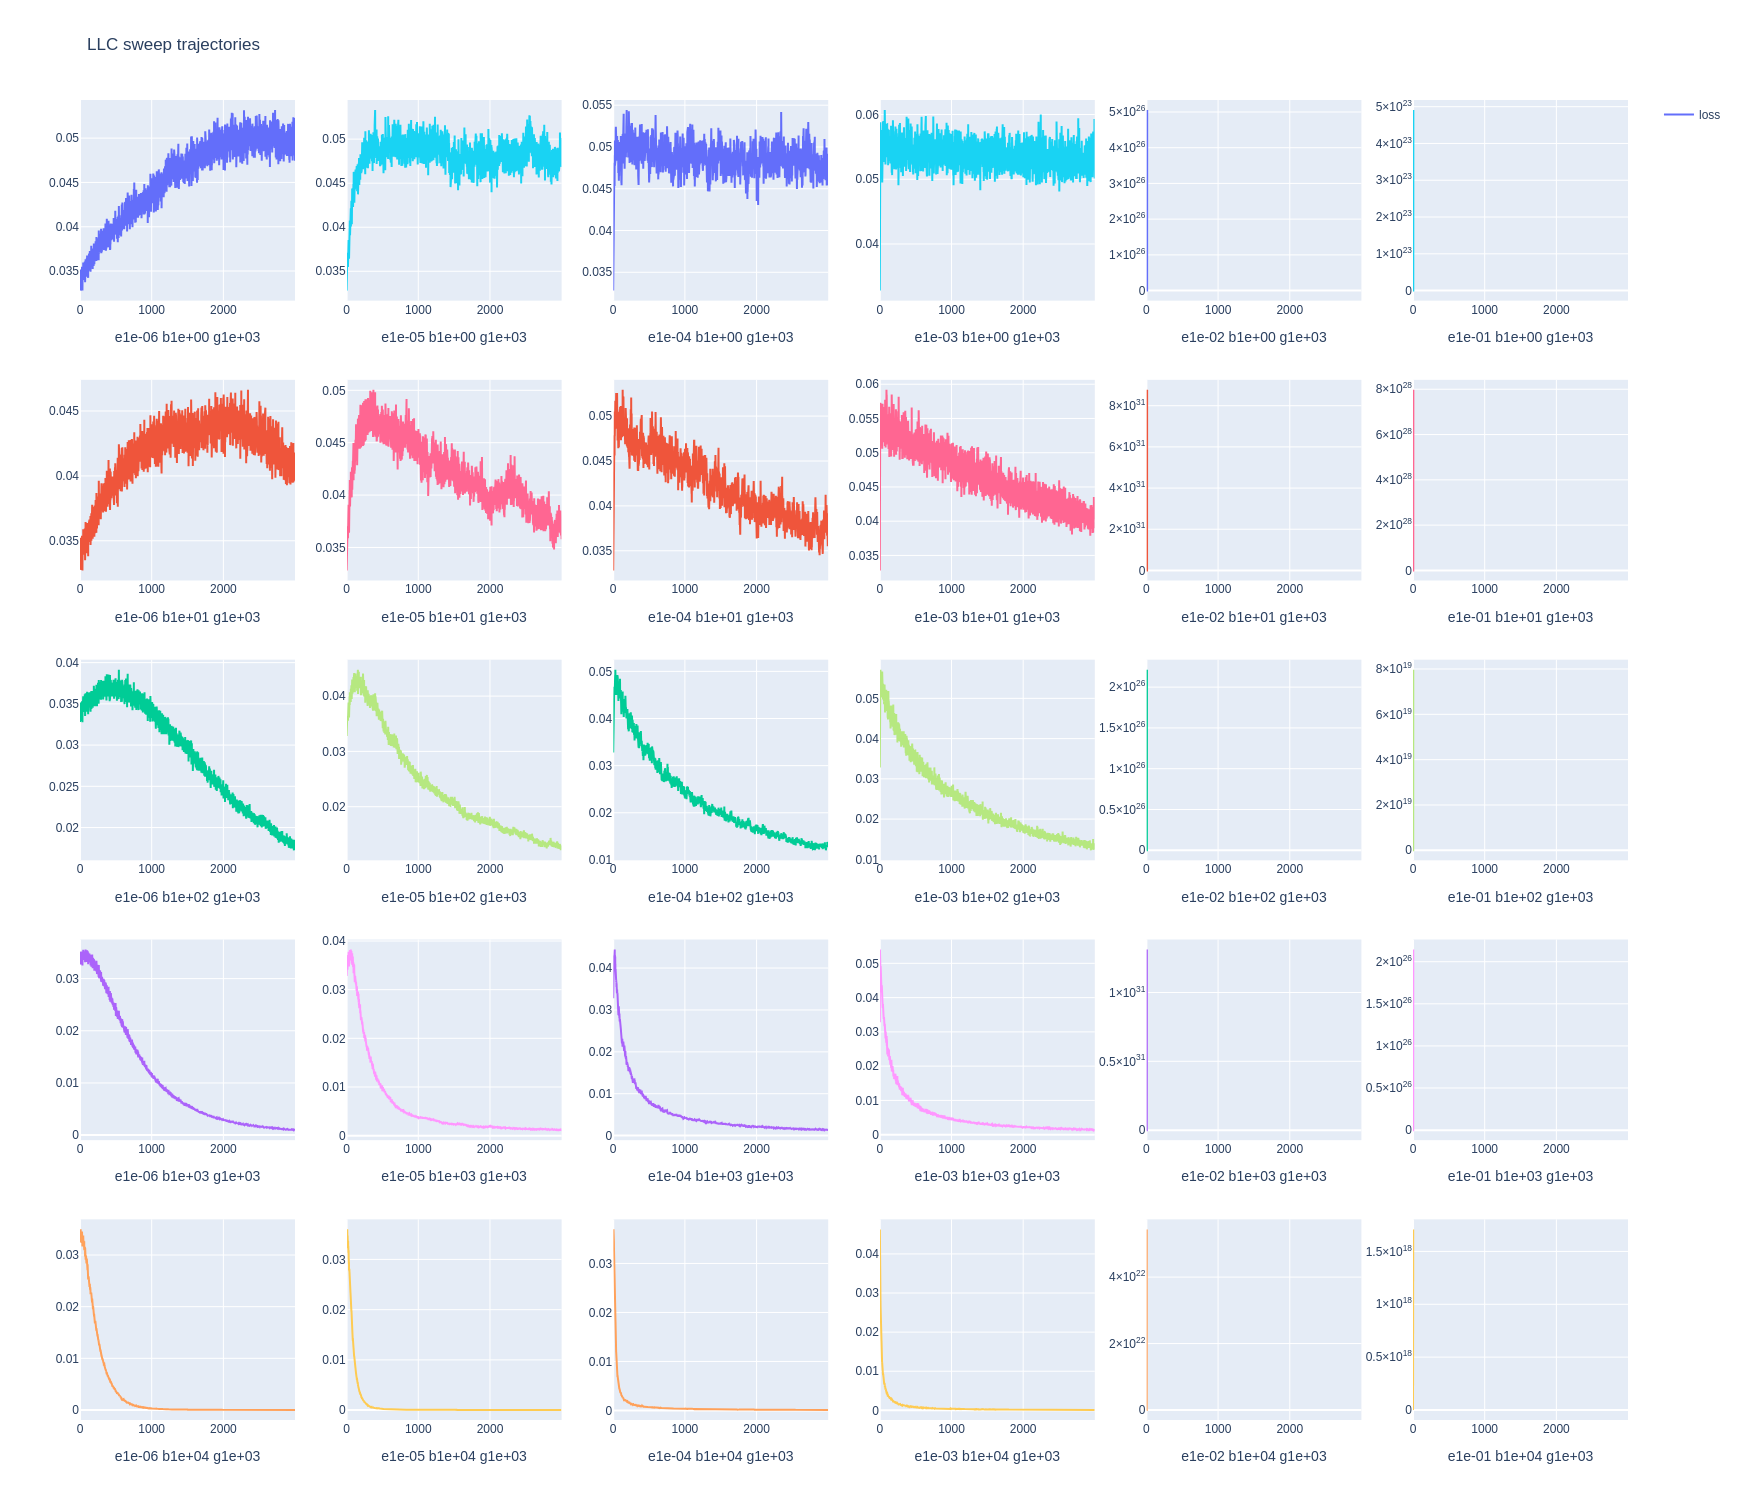

In [28]:
plot_trace_sweep(trace1, eps_l, beta_l, gamma_l).show()

In [22]:
model_traj = MLP4.stack([model[0].to(device) for model in models[:]])

In [23]:
model_traj.num_instances()

212

In [24]:
model_traj = model_traj[:300]

In [30]:
llc, _ = get_llc(
    #model_traj, dataset, eps=1e-5, beta=100., gamma=1.0, chains=1, replacement=True, positive=False, pos_func=lambda x: x, #parallel_chain=True,
    model_traj, dataset, eps=1e-5, beta=1e-2, gamma=1e-3, chains=1, replacement=True, positive=False, pos_func=lambda x: x, #parallel_chain=True,
)

SGLD:   0%|          | 0/2000 [00:00<?, ?it/s]

In [31]:
import gc
t.cuda.empty_cache()
gc.collect()

18

In [32]:
loss = full_train_loss(model_traj, dataset)

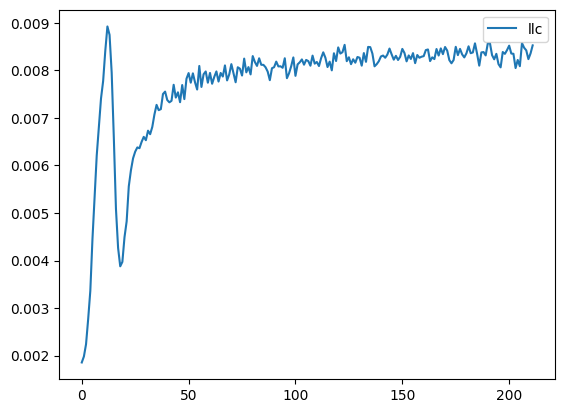

In [34]:
plt.plot(llc.tolist(), label='llc')
#plt.plot((loss * 1).tolist(), label='loss')
plt.legend()
plt.show()

In [7]:
plt.plot(llc.tolist(), label='llc_abs')
plt.plot(llc_neg.tolist(), label='llc')
plt.plot((loss*10).tolist(), label='loss')
plt.legend()
plt.show()

NameError: name 'llc' is not defined

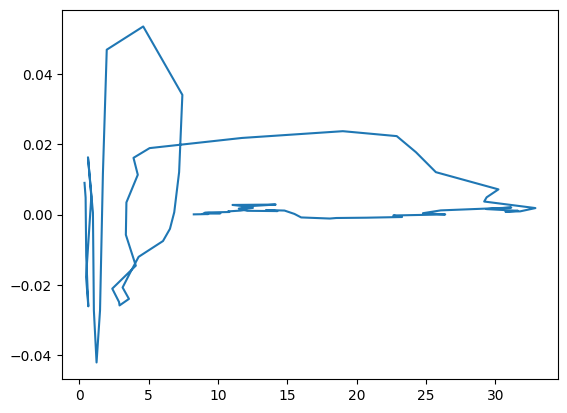

In [80]:
plt.plot(llc[:80], np.gradient(np.gradient(loss[:80].tolist())))

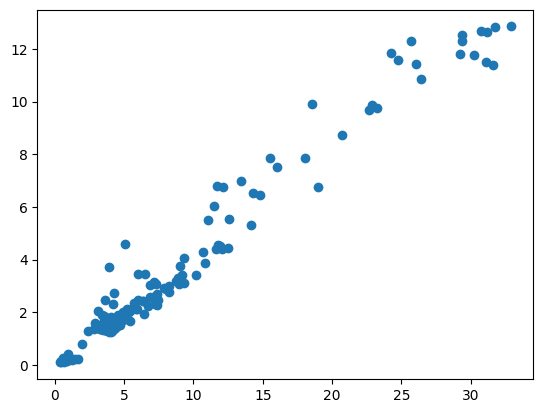

In [59]:
plt.scatter(llc.detach().cpu().numpy(), llc_square.detach().cpu().numpy())

In [60]:
llc = llc.detach().cpu().numpy()
llc_square = llc_square.detach().cpu().numpy()

In [62]:
(llc * llc_square).sum() / (llc**2).sum()

np.float32(0.41292116)

In [63]:
np.corrcoef(llc, llc_square)

array([[1.        , 0.98457619],
       [0.98457619, 1.        ]])

In [35]:
llc[20]

tensor(-63.0355, device='cuda:0', grad_fn=<SelectBackward0>)

In [111]:
plt.plot

torch.Size([667])

In [117]:
path = '/workspace/models/2024_07_31_03_48_41_Z_48_2__long'
models, params = load_models(path)
model0 = models[0].to(device)

100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


In [118]:
params.group_string = 'Z(48,2);twZ(48)'
params.train_frac=1.
params.delta_frac=[0.,0.]

In [119]:
dataset = GroupData(params)

Intersection size: 6912/9216 (0.75)
Added 6912 elements from intersection
Added 0 elements from group 0: Z(48,2)
Added 0 elements from group 1: twZ(48)
Train set size: 6912/9216 (0.75)


In [120]:
llc0, _ = get_llc(
    model0, dataset, eps=1e-5, beta=100., gamma=1.0, chains=1, replacement=True, positive=True, pos_func=lambda x: x.abs(), #parallel_chain=True,
)

SGLD:   0%|          | 0/2000 [00:00<?, ?it/s]

In [121]:
path = '/workspace/models/2024_07_31_04_29_56_twZ_48__long'
models, params = load_models(path)
model1 = models[0].to(device)

100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


In [122]:
llc1, _ = get_llc(
    model1, dataset, eps=1e-5, beta=100., gamma=1.0, chains=1, replacement=True, positive=True, pos_func=lambda x: x.abs(), #parallel_chain=True,
)

SGLD:   0%|          | 0/2000 [00:00<?, ?it/s]

In [123]:
llc0.mean()

tensor(1.4575, device='cuda:0', grad_fn=<MeanBackward0>)

In [124]:
llc1.mean()

tensor(1.6735, device='cuda:0', grad_fn=<MeanBackward0>)

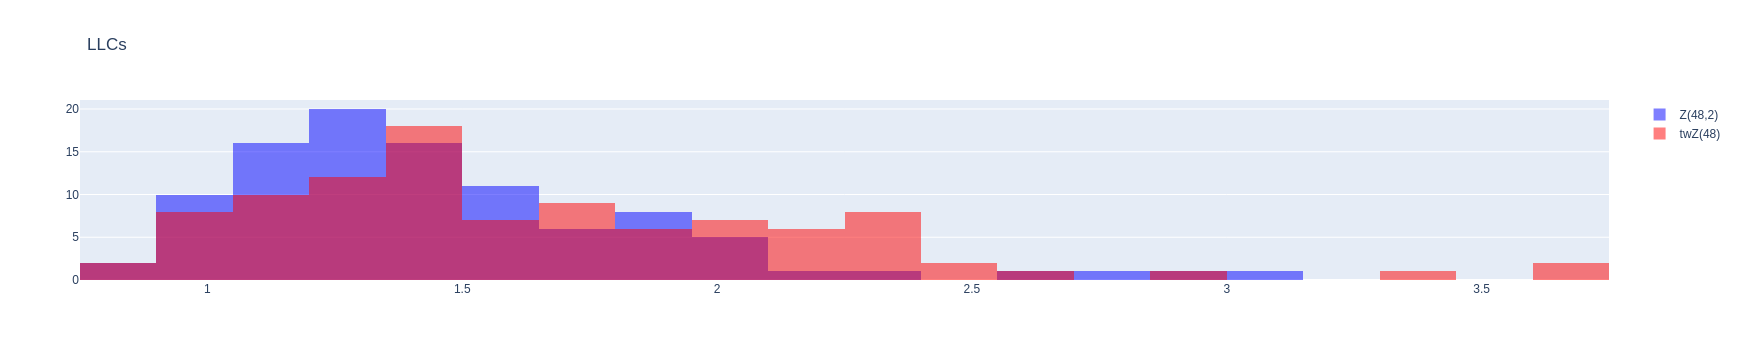

In [125]:
xbins = dict(
    start=0,
    end=5,
    size=0.15
)
trace1 = go.Histogram(
    x=llc0.tolist(),
    opacity=0.5,
    name='Z(48,2)',
    marker=dict(color='blue'),
    xbins=xbins,
)
trace2 = go.Histogram(
    x=llc1.tolist(),
    opacity=0.5,
    name='twZ(48)',
    marker=dict(color='red'),
    xbins=xbins
)
data = [trace1, trace2]
layout = go.Layout(
    title='LLCs',
    barmode='overlay'
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [112]:
llc1

tensor([ 0.9874,  1.4141,  1.4654,  0.9344,  2.7153,  3.1483,  3.3290,  3.8219,
         6.8089,  4.3458,  1.3155,  1.5659,  1.7398,  1.5526,  3.5401,  1.2740,
         3.2713,  2.1652,  1.7226,  1.7287,  2.6084,  2.2665,  1.7206,  1.8243,
         1.8860,  8.4086,  1.2441,  1.4212,  1.4531,  1.8648,  1.5098,  3.9260,
         1.3085,  2.0944,  1.3203,  2.4873,  1.1488,  1.9138,  1.6414,  1.4984,
         1.4920,  2.7991,  1.7223,  2.0051,  1.5686,  1.4028,  1.6996,  1.5014,
         1.8282,  9.3132,  1.4149,  2.0086,  1.1269,  1.1891,  3.4945,  2.5289,
         1.6784,  2.5197,  1.8604,  2.2619,  3.0042,  1.6799,  1.3973,  8.4145,
         1.3617,  2.1481,  1.6027,  3.7118,  1.3719,  3.6098,  3.5865,  1.4018,
         1.7682,  1.1635,  1.4641,  1.8655,  1.4411,  1.5734,  1.3905, 13.4592,
         1.5714,  1.3954,  1.7114,  1.5876,  1.0525,  1.9853,  6.0591,  1.6110,
         3.1338,  1.5852,  1.8222,  3.2436,  1.5336,  4.4949,  1.5678,  1.3948,
         1.2458,  0.9617,  1.0139,  4.55